# Solving Tic-Tac-Toe with RL

## Setup

### Imports

In [ ]:
from abc import ABC, abstractmethod
import os
import pickle
import collections
import numpy as np
import random
import logging
import sys
import matplotlib.pylab as plt

### Params

In [ ]:
class Args:

    agent_type = "q" # 'q' for Q-learning, 's' for SARSA, Specify the computer agent learning algorithm.
    path = None # Specify the path for the agent pickle file. Defaults to q_agent.pkl for AGENT_TYPE='q' and "sarsa_agent.pkl for AGENT_TYPE='s'.
    load = False # whether to load trained agent
    teacher_episodes = 0 # employ teacher agent who knows the optimal strategy and will play for TEACHER_EPISODES games

In [ ]:
def get_args():
    args = Args()
    # set default path
    if args.path is None:
        args.path = 'q_agent.pkl' if args.agent_type == 'q' else 'sarsa_agent.pkl'
    return args

### Logger

In [ ]:
logging.basicConfig(stream=sys.stdout,
                    level = logging.DEBUG,
                    format='%(asctime)s [%(levelname)s] : %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

logger = logging.getLogger('Tic-Tac-Toe Logger')

## Utilities

### Environment

In [ ]:
class Game:
    """ The game class. New instance created for each new game. """
    def __init__(self, agent, teacher=None):
        self.agent = agent
        self.teacher = teacher
        # initialize the game board
        self.board = [['-', '-', '-'], ['-', '-', '-'], ['-', '-', '-']]

    def playerMove(self):
        """
        Querry player for a move and update the board accordingly.
        """
        if self.teacher is not None:
            action = self.teacher.makeMove(self.board)
            self.board[action[0]][action[1]] = 'X'
        else:
            printBoard(self.board)
            while True:
                move = input("Your move! Please select a row and column from 0-2 "
                             "in the format row,col: ")
                print('\n')
                try:
                    row, col = int(move[0]), int(move[2])
                except ValueError:
                    print("INVALID INPUT! Please use the correct format.")
                    continue
                if row not in range(3) or col not in range(3) or not self.board[row][col] == '-':
                    print("INVALID MOVE! Choose again.")
                    continue
                self.board[row][col] = 'X'
                break

    def agentMove(self, action):
        """
        Update board according to agent's move.
        """
        self.board[action[0]][action[1]] = 'O'

    def checkForWin(self, key):
        """
        Check to see whether the player/agent with token 'key' has won.
        Returns a boolean holding truth value.
        Parameters
        ----------
        key : string
            token of most recent player. Either 'O' or 'X'
        """
        # check for player win on diagonals
        a = [self.board[0][0], self.board[1][1], self.board[2][2]]
        b = [self.board[0][2], self.board[1][1], self.board[2][0]]
        if a.count(key) == 3 or b.count(key) == 3:
            return True
        # check for player win on rows/columns
        for i in range(3):
            col = [self.board[0][i], self.board[1][i], self.board[2][i]]
            row = [self.board[i][0], self.board[i][1], self.board[i][2]]
            if col.count(key) == 3 or row.count(key) == 3:
                return True
        return False

    def checkForDraw(self):
        """
        Check to see whether the game has ended in a draw. Returns a
        boolean holding truth value.
        """
        draw = True
        for row in self.board:
            for elt in row:
                if elt == '-':
                    draw = False
        return draw

    def checkForEnd(self, key):
        """
        Checks if player/agent with token 'key' has ended the game. Returns -1
        if the game is still going, 0 if it is a draw, and 1 if the player/agent
        has won.
        Parameters
        ----------
        key : string
            token of most recent player. Either 'O' or 'X'
        """
        if self.checkForWin(key):
            if self.teacher is None:
                printBoard(self.board)
                if key == 'X':
                    logger.info("Player wins!")
                else:
                    logger.info("RL agent wins!")
            return 1
        elif self.checkForDraw():
            if self.teacher is None:
                printBoard(self.board)
                logger.info("It's a draw!")
            return 0
        return -1

    def playGame(self, player_first):
        """ 
        Begin the tic-tac-toe game loop. 
        Parameters
        ----------
        player_first : boolean
            Whether or not the player will move first. If False, the
            agent goes first.
        """
        # Initialize the agent's state and action
        if player_first:
            self.playerMove()
        prev_state = getStateKey(self.board)
        prev_action = self.agent.get_action(prev_state)

        # iterate until game is over
        while True:
            # execute oldAction, observe reward and state
            self.agentMove(prev_action)
            check = self.checkForEnd('O')
            if not check == -1:
                # game is over. +1 reward if win, 0 if draw
                reward = check
                break
            self.playerMove()
            check = self.checkForEnd('X')
            if not check == -1:
                # game is over. -1 reward if lose, 0 if draw
                reward = -1*check
                break
            else:
                # game continues. 0 reward
                reward = 0
            new_state = getStateKey(self.board)

            # determine new action (epsilon-greedy)
            new_action = self.agent.get_action(new_state)
            # update Q-values
            self.agent.update(prev_state, new_state, prev_action, new_action, reward)
            # reset "previous" values
            prev_state = new_state
            prev_action = new_action
            # append reward

        # Game over. Perform final update
        self.agent.update(prev_state, None, prev_action, None, reward)

    def start(self):
        """
        Function to determine who moves first, and subsequently, start the game.
        If a teacher is employed, first mover is selected at random.
        If a human is playing, the human is asked whether he/she would
        like to move fist. 
        """
        if self.teacher is not None:
            # During teaching, chose who goes first randomly with equal probability
            if random.random() < 0.5:
                self.playGame(player_first=False)
            else:
                self.playGame(player_first=True)
        else:
            while True:
                response = input("Would you like to go first? [y/n]: ")
                print('')
                if response == 'n' or response == 'no':
                    self.playGame(player_first=False)
                    break
                elif response == 'y' or response == 'yes':
                    self.playGame(player_first=True)
                    break
                else:
                    logger.info("Invalid input. Please enter 'y' or 'n'.")

In [ ]:
def printBoard(board):
    """
    Prints the game board as text output to the terminal.
    Parameters
    ----------
    board : list of lists
        the current game board
    """
    print('    0   1   2\n')
    for i, row in enumerate(board):
        print('%i   ' % i, end='')
        for elt in row:
            print('%s   ' % elt, end='')
        print('\n')

In [ ]:
def getStateKey(board):
    """
    Converts 2D list representing the board state into a string key
    for that state. Keys are used for Q-value hashing.
    Parameters
    ----------
    board : list of lists
        the current game board
    """
    key = ''
    for row in board:
        for elt in row:
            key += elt
    return key

In [ ]:
class Teacher:
    """ 
    A class to implement a teacher that knows the optimal playing strategy.
    Teacher returns the best move at any time given the current state of the game.
    Note: things are a bit more hard-coded here, as this was not the main focus of
    the exercise so I did not spend as much time on design/style. Everything works
    properly when tested.
    Parameters
    ----------
    level : float 
        teacher ability level. This is a value between 0-1 that indicates the
        probability of making the optimal move at any given time.
    """

    def __init__(self, level=0.9):
        """
        Ability level determines the probability that the teacher will follow
        the optimal strategy as opposed to choosing a random available move.
        """
        self.ability_level = level

    def win(self, board, key='X'):
        """ If we have two in a row and the 3rd is available, take it. """
        # Check for diagonal wins
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count('-') == 1 and a.count(key) == 2:
            ind = a.index('-')
            return ind, ind
        elif b.count('-') == 1 and b.count(key) == 2:
            ind = b.index('-')
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
        # Now check for 2 in a row/column + empty 3rd
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count('-') == 1 and c.count(key) == 2:
                ind = c.index('-')
                return ind, i
            elif d.count('-') == 1 and d.count(key) == 2:
                ind = d.index('-')
                return i, ind
        return None

    def blockWin(self, board):
        """ Block the opponent if she has a win available. """
        return self.win(board, key='O')

    def fork(self, board):
        """ Create a fork opportunity such that we have 2 threats to win. """
        # Check all adjacent side middles
        if board[1][0] == 'X' and board[0][1] == 'X':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'X' and board[2][1] == 'X':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'X' and board[1][2] == 'X':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'X' and board[0][1] == 'X':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners
        elif board[0][0] == 'X' and board[2][2] == 'X':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'X' and board[0][2] == 'X':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def blockFork(self, board):
        """ Block the opponents fork if she has one available. """
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        # Check all adjacent side middles
        if board[1][0] == 'O' and board[0][1] == 'O':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'O' and board[2][1] == 'O':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'O' and board[1][2] == 'O':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'O' and board[0][1] == 'O':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        # Check all cross corners (first check for double fork opp using the corners array)
        elif corners.count('-') == 1 and corners.count('O') == 2:
            return 1, 2
        elif board[0][0] == 'O' and board[2][2] == 'O':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'O' and board[0][2] == 'O':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def center(self, board):
        """ Pick the center if it is available. """
        if board[1][1] == '-':
            return 1, 1
        return None

    def corner(self, board):
        """ Pick a corner move. """
        # Pick opposite corner of opponent if available
        if board[0][0] == 'O' and board[2][2] == '-':
            return 2, 2
        elif board[2][0] == 'O' and board[0][2] == '-':
            return 0, 2
        elif board[0][2] == 'O' and board[2][0] == '-':
            return 2, 0
        elif board[2][2] == 'O' and board[0][0] == '-':
            return 0, 0
        # Pick any corner if no opposites are available
        elif board[0][0] == '-':
            return 0, 0
        elif board[2][0] == '-':
            return 2, 0
        elif board[0][2] == '-':
            return 0, 2
        elif board[2][2] == '-':
            return 2, 2
        return None

    def sideEmpty(self, board):
        """ Pick an empty side. """
        if board[1][0] == '-':
            return 1, 0
        elif board[2][1] == '-':
            return 2, 1
        elif board[1][2] == '-':
            return 1, 2
        elif board[0][1] == '-':
            return 0, 1
        return None

    def randomMove(self, board):
        """ Chose a random move from the available options. """
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == '-':
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        """
        Trainer goes through a hierarchy of moves, making the best move that
        is currently available each time. A touple is returned that represents
        (row, col).
        """
        # Chose randomly with some probability so that the teacher does not always win
        if random.random() > self.ability_level:
            return self.randomMove(board)
        # Follow optimal strategy
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

### Agents

In [ ]:
class Learner(ABC):
    """
    Parent class for Q-learning and SARSA agents.
    Parameters
    ----------
    alpha : float 
        learning rate
    gamma : float
        temporal discounting rate
    eps : float 
        probability of random action vs. greedy action
    eps_decay : float
        epsilon decay rate. Larger value = more decay
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        # Agent parameters
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        # Possible actions correspond to the set of all x,y coordinate pairs
        self.actions = []
        for i in range(3):
            for j in range(3):
                self.actions.append((i,j))
        # Initialize Q values to 0 for all state-action pairs.
        # Access value for action a, state s via Q[a][s]
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
        # Keep a list of reward received at each episode
        self.rewards = []

    def get_action(self, s):
        """
        Select an action given the current game state.
        Parameters
        ----------
        s : string
            state
        """
        # Only consider the allowed actions (empty board spaces)
        possible_actions = [a for a in self.actions if s[a[0]*3 + a[1]] == '-']
        if random.random() < self.eps:
            # Random choose.
            action = possible_actions[random.randint(0,len(possible_actions)-1)]
        else:
            # Greedy choose.
            values = np.array([self.Q[a][s] for a in possible_actions])
            # Find location of max
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
                # If multiple actions were max, then sample from them
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
                # If unique max action, select that one
                ix_select = ix_max[0]
            action = possible_actions[ix_select]

        # update epsilon; geometric decay
        self.eps *= (1.-self.eps_decay)

        return action

    def save(self, path):
        """ Pickle the agent object instance to save the agent's state. """
        if os.path.isfile(path):
            os.remove(path)
        f = open(path, 'wb')
        pickle.dump(self, f)
        logger.info('model saved at {}'.format(path))
        f.close()

    @abstractmethod
    def update(self, s, s_, a, a_, r):
        pass

In [ ]:
class Qlearner(Learner):
    """
    A class to implement the Q-learning agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        super().__init__(alpha, gamma, eps, eps_decay)

    def update(self, s, s_, a, a_, r):
        """
        Perform the Q-Learning update of Q values.
        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action. NOT used by Q-learner!
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            # hold list of Q values for all a_,s_ pairs. We will access the max later
            possible_actions = [action for action in self.actions if s_[action[0]*3 + action[1]] == '-']
            Q_options = [self.Q[action][s_] for action in possible_actions]
            # update
            self.Q[a][s] += self.alpha*(r + self.gamma*max(Q_options) - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)

In [ ]:
class SARSAlearner(Learner):
    """
    A class to implement the SARSA agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        super().__init__(alpha, gamma, eps, eps_decay)

    def update(self, s, s_, a, a_, r):
        """
        Perform the SARSA update of Q values.
        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            self.Q[a][s] += self.alpha*(r + self.gamma*self.Q[a_][s_] - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)

### Simulation

In [ ]:
class GameLearning(object):
    """
    A class that holds the state of the learning process. Learning
    agents are created/loaded here, and a count is kept of the
    games that have been played.
    """
    def __init__(self, args, alpha=0.5, gamma=0.9, epsilon=0.1):

        if args.load:
            # load an existing agent and continue training
            if not os.path.isfile(args.path):
                raise ValueError("Cannot load agent: file does not exist.")
            with open(args.path, 'rb') as f:
                agent = pickle.load(f)
        else:
            # check if agent state file already exists, and ask
            # user whether to overwrite if so
            if os.path.isfile(args.path):
                print('An agent is already saved at {}.'.format(args.path))
                while True:
                    response = input("Are you sure you want to overwrite? [y/n]: ")
                    if response.lower() in ['y', 'yes']:
                        break
                    elif response.lower() in ['n', 'no']:
                        print("OK. Quitting.")
                        sys.exit(0)
                    else:
                        print("Invalid input. Please choose 'y' or 'n'.")
            if args.agent_type == "q":
                agent = Qlearner(alpha,gamma,epsilon)
            else:
                agent = SARSAlearner(alpha,gamma,epsilon)

        self.games_played = 0
        self.path = args.path
        self.agent = agent

    def beginPlaying(self):
        """ Loop through game iterations with a human player. """
        print("Welcome to Tic-Tac-Toe. You are 'X' and the computer is 'O'.")

        def play_again():
            logger.info("Games played: %i" % self.games_played)
            while True:
                play = input("Do you want to play again? [y/n]: ")
                if play == 'y' or play == 'yes':
                    return True
                elif play == 'n' or play == 'no':
                    return False
                else:
                    print("Invalid input. Please choose 'y' or 'n'.")

        while True:
            game = Game(self.agent)
            game.start()
            self.games_played += 1
            self.agent.save(self.path)
            if not play_again():
                print("OK. Quitting.")
                break

    def beginTeaching(self, episodes):
        """ Loop through game iterations with a teaching agent. """
        teacher = Teacher()
        # Train for alotted number of episodes
        while self.games_played < episodes:
            game = Game(self.agent, teacher=teacher)
            game.start()
            self.games_played += 1
            # Monitor progress
            if self.games_played % 1000 == 0:
                logger.info("Games played: %i" % self.games_played)
        # save final agent
        self.agent.save(self.path)

In [ ]:
def plot_agent_reward(rewards):
    """ Function to plot agent's accumulated reward vs. iteration """
    plt.plot(np.cumsum(rewards))
    plt.title('Agent Cumulative Reward vs. Iteration')
    plt.ylabel('Reward')
    plt.xlabel('Episode')
    plt.show()

## Jobs

In [ ]:
logger.info('JOB START: employing expert to play game with q-learning')
# get default args
args = get_args()
# set args
args.teacher_episodes = 1000
# initialize game instance
gl = GameLearning(args)
# letting teacher/expert play
gl.beginTeaching(args.teacher_episodes)
logger.info('JOB END: employing expert to play game with q-learning')

08-Nov-21 10:52:21 [INFO] : JOB START: employing expert to play game with q-learning
An agent is already saved at q_agent.pkl.
Are you sure you want to overwrite? [y/n]: y
08-Nov-21 10:52:23 [INFO] : Games played: 1000
08-Nov-21 10:52:23 [INFO] : JOB END: employing expert to play game with q-learning


In [ ]:
logger.info('JOB START: playing game with on q-learning')
# get default args
args = get_args()
# initialize game instance
gl = GameLearning(args)
# start playing
gl.beginPlaying()
logger.info('JOB END: playing game with on q-learning')

08-Nov-21 10:53:20 [INFO] : JOB START: playing game with on q-learning
An agent is already saved at q_agent.pkl.
Are you sure you want to overwrite? [y/n]: y
Welcome to Tic-Tac-Toe. You are 'X' and the computer is 'O'.
Would you like to go first? [y/n]: y

    0   1   2

0   -   -   -   

1   -   -   -   

2   -   -   -   

Your move! Please select a row and column from 0-2 in the format row,col: 2,0


    0   1   2

0   -   -   -   

1   -   O   -   

2   X   -   -   

Your move! Please select a row and column from 0-2 in the format row,col: 0,0


    0   1   2

0   X   -   -   

1   O   O   -   

2   X   -   -   

Your move! Please select a row and column from 0-2 in the format row,col: 1,2


    0   1   2

0   X   -   -   

1   O   O   X   

2   X   O   -   

Your move! Please select a row and column from 0-2 in the format row,col: 0,1


    0   1   2

0   X   X   O   

1   O   O   X   

2   X   O   -   

Your move! Please select a row and column from 0-2 in the format row,col: 2,2


In [ ]:
logger.info('JOB START: employing expert to play game with sarsa')
# get default args
args = get_args()
# set args
args.agent_type = 's'
args.teacher_episodes = 1000
# initialize game instance
gl = GameLearning(args)
# letting teacher/expert play
gl.beginTeaching(args.teacher_episodes)
logger.info('JOB END: employing expert to play game with sarsa')

08-Nov-21 10:57:33 [INFO] : JOB START: employing expert to play game with sarsa
An agent is already saved at q_agent.pkl.
Are you sure you want to overwrite? [y/n]: y
08-Nov-21 10:57:46 [INFO] : Games played: 1000
08-Nov-21 10:57:46 [INFO] : JOB END: employing expert to play game with sarsa


In [ ]:
logger.info('JOB START: playing game with on sarsa')
# get default args
args = get_args()
# set args
args.agent_type = 's'
# initialize game instance
gl = GameLearning(args)
# start playing
gl.beginPlaying()
logger.info('JOB END: playing game with on sarsa')

08-Nov-21 10:58:27 [INFO] : JOB START: playing game with on sarsa
An agent is already saved at q_agent.pkl.
Are you sure you want to overwrite? [y/n]: y
Welcome to Tic-Tac-Toe. You are 'X' and the computer is 'O'.
Would you like to go first? [y/n]: y

    0   1   2

0   -   -   -   

1   -   -   -   

2   -   -   -   

Your move! Please select a row and column from 0-2 in the format row,col: 0,0


    0   1   2

0   X   -   -   

1   -   -   -   

2   -   -   O   

Your move! Please select a row and column from 0-2 in the format row,col: 2,0


    0   1   2

0   X   -   -   

1   -   -   O   

2   X   -   O   

Your move! Please select a row and column from 0-2 in the format row,col: 1,0


    0   1   2

0   X   -   -   

1   X   -   O   

2   X   -   O   

Player wins!
08-Nov-21 10:59:19 [INFO] : Games played: 1
Do you want to play again? [y/n]: n
OK. Quitting.
08-Nov-21 10:59:24 [INFO] : JOB END: playing game with on sarsa


08-Nov-21 11:06:02 [INFO] : JOB START: plotting agent rewards


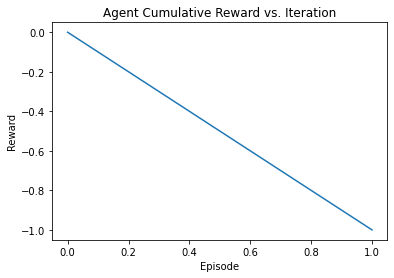

08-Nov-21 11:06:02 [INFO] : JOB END: plotting agent rewards


In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.info('JOB START: plotting agent rewards')
# get default args
args = get_args()
# loading agent
with open(args.path, 'rb') as f:
    agent = pickle.load(f)
# plot rewards
plot_agent_reward(agent.rewards)
logger.info('JOB END: plotting agent rewards')